## Figures for analysis of the MIBI dataset
This notebook reproduces Figures 4F, 5A-C, 7D-F, 7I, S4F-G

In [1]:
import os
import pandas as pd
import re
import numpy as np
import glob
from pathlib import Path
from scipy import sparse
import scanpy as sc
from copy import deepcopy
import pickle
from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr
from scipy.stats import zscore


In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
sns.set_style('ticks')

<h3> Load data </h3>

In [28]:
out_dir = '../out.MIBI.060121/'
os.makedirs(out_dir, exist_ok=True)

In [29]:
cell_data_lite=pd.read_hdf(out_dir + 'MSKCC_SCLC_mibi_cell_table.h5','df',index_col=0)
sample_df = pd.read_csv(out_dir + 'MSKCC_SCLC_mibi_sample_table.csv',index_col=0)
sclc_sample_df = pd.read_csv(out_dir + 'MSKCC_SCLC_mibi_tme_table.csv',index_col=0)
tnbc_feature_df=pd.read_csv(out_dir + 'MSKCC_TNBC_mibi_tme_table.csv',index_col=0)

### Figure 4F

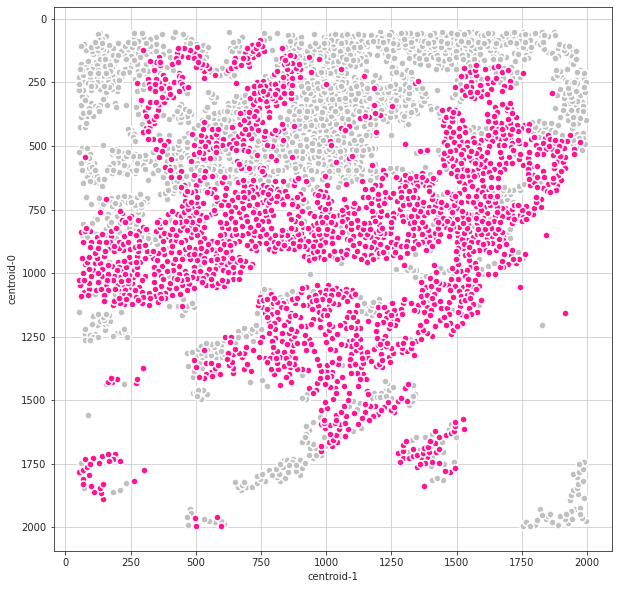

In [7]:
plt.figure(figsize=(10,10))
fov1 = cell_data_lite[cell_data_lite.TMA_coord=='X4Y10'].copy()

fov1= fov1[(fov1.Cluster=='Tumor')&(fov1['PLCG2+']==0)]
sns.scatterplot(x='centroid-1',y='centroid-0',data=fov1.sort_values("Cluster",ascending=False),s=50,alpha=1,palette='Set2',color='silver',legend=False,  linewidth=1.5)
fov1 = cell_data_lite[cell_data_lite.TMA_coord=='X4Y10'].copy()
fov1= fov1[(fov1.Cluster=='Tumor')&(fov1['PLCG2+']==1)]
sns.scatterplot(x='centroid-1',y='centroid-0',data=fov1.sort_values("Cluster",ascending=False),s=50,alpha=1,palette='Set2',color='deeppink',legend=False,  linewidth=1.5)
plt.grid(b=None)
plt.gca().invert_yaxis()
#plt.savefig('fig/PLCG2_tumor.png',dpi=300,facecolor='white')

### Figure 5A

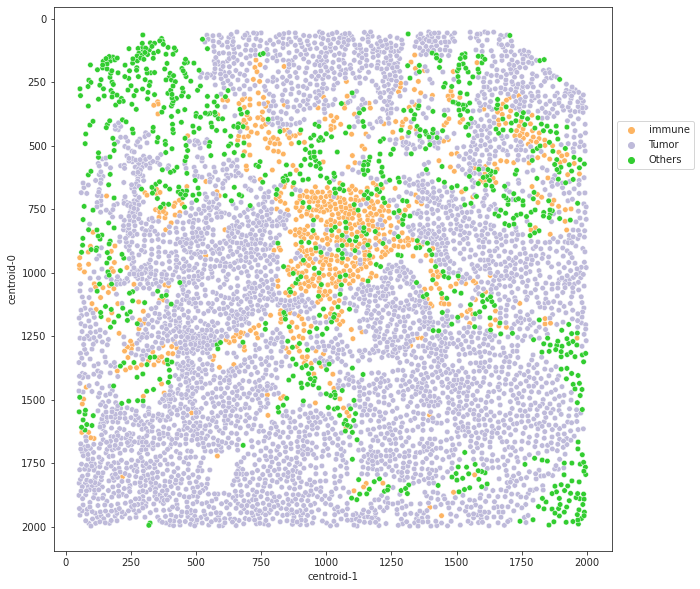

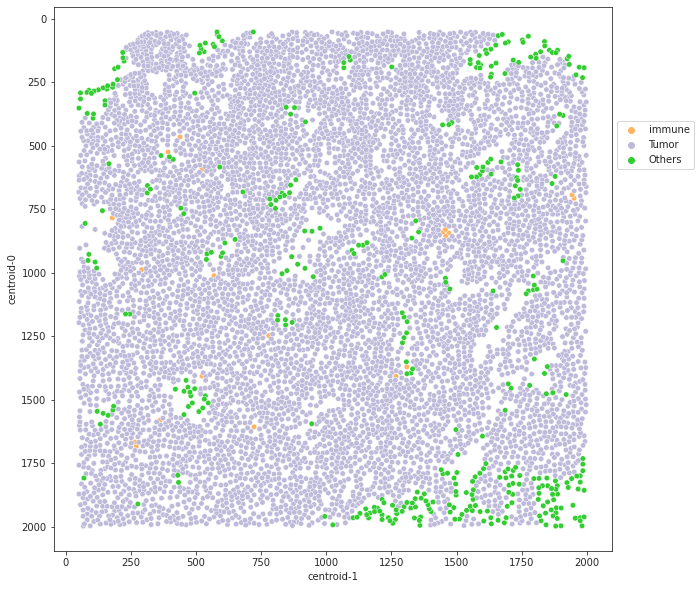

In [8]:
cmap3=['#fdb462','#bebada','#32CD30'] ##B2D2A4 8dd3c7
fov_list = ['X5Y13','X9Y3']
for fov in fov_list:
    plt.figure(figsize=(10,10))
    fov1 = cell_data_lite[cell_data_lite.TMA_coord==fov].copy()
    sns.scatterplot(x='centroid-1',y='centroid-0',data=fov1.sort_values("immune vs tumor updated",ascending=False),s=30,alpha=1,hue='immune vs tumor updated',palette=cmap3,legend=True)
    plt.gca().invert_yaxis()
    plt.grid(False)
    plt.legend(bbox_to_anchor=(1, 0.8))


### Figure 5B 

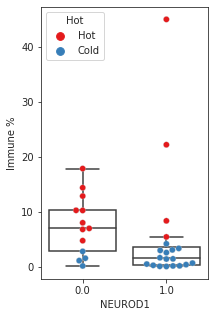

In [9]:
plt.figure(figsize=(3,5))
sns.boxplot(data=sclc_sample_df,x='NEUROD1',y='Immune %',boxprops={'facecolor':'None'},showfliers=False)
sns.swarmplot(data=sclc_sample_df,x='NEUROD1',y='Immune %',hue='Hot',hue_order=['Hot','Cold'],size=6,palette='Set1',linewidth=0.3,edgecolor='lightgray')
plt.grid(False)


### Figure 5C 

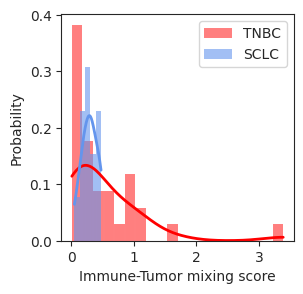

In [10]:
plt.figure(figsize=(3,3),dpi=100)
bwadjust=1
immune_threshold = 250
bins=20
sns.histplot(tnbc_feature_df[tnbc_feature_df['Immune count']>immune_threshold]['interaction'],linewidth=0.01,fill=1,shrink=1,stat='probability',bins=bins,line_kws={"linewidth":2,"alpha":1},kde_kws={'bw_adjust':bwadjust},color='red', kde=True, label="TNBC",alpha=0.5)
sns.histplot(sclc_sample_df[sclc_sample_df['Immune count']>immune_threshold]['interaction'],linewidth=0.01,fill=1,shrink=1,stat='probability',line_kws={"linewidth":2,"alpha":1},bins=5,kde_kws={'bw_adjust':bwadjust},color='cornflowerblue', kde=True, label="SCLC",alpha=0.6)

plt.grid(False)
plt.xlabel('Immune-Tumor mixing score')
plt.legend() 


### Figure 7D

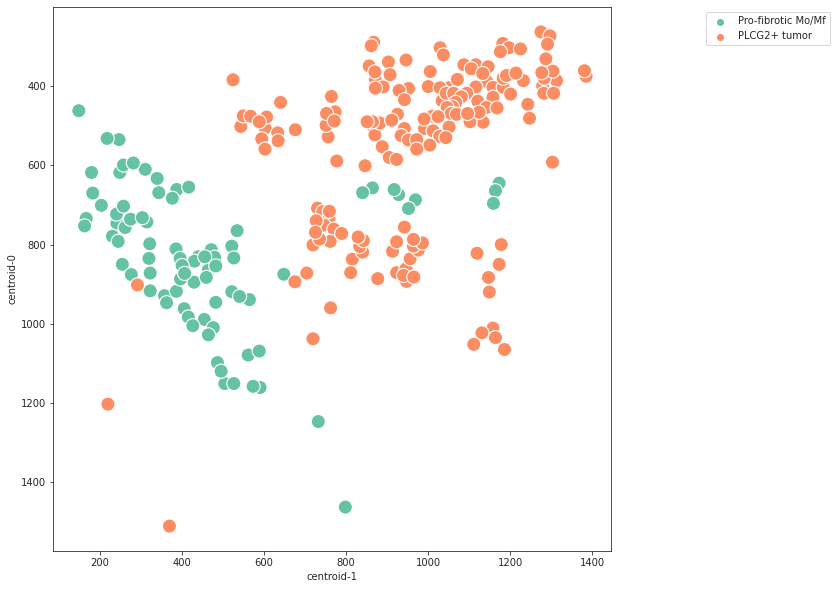

In [11]:
plt.figure(figsize=(10,10))
crop_coord1=[130,240]
crop_size=1280
fov1 = cell_data_lite[cell_data_lite.TMA_coord=='X8Y5'].copy()
fov1=fov1[fov1.PLCG2_Myeloid!='Others']
fov1=fov1[(fov1['centroid-1']>crop_coord1[0])&(fov1['centroid-1']<(crop_coord1[0]+crop_size))&(fov1['centroid-0']>crop_coord1[1])&(fov1['centroid-0']<(crop_coord1[1]+crop_size))]

sns.scatterplot(x='centroid-1',y='centroid-0',data=fov1.sort_values("PLCG2_Myeloid",ascending=False),s=200,alpha=1,hue='PLCG2_Myeloid',palette='Set2',legend=True)
plt.grid(False)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.4, 1))

### Figure 7E

In [12]:
from statsmodels.stats.multitest import multipletests
import warnings
import itertools
warnings.filterwarnings('ignore')


In [13]:
def partial_cor(X,y, cov):
    cvar = np.atleast_2d(cov)
    beta_x = np.linalg.lstsq(cvar, X, rcond=None)[0]
    beta_y = np.linalg.lstsq(cvar, y, rcond=None)[0]
    res_x = X - np.dot(cvar, beta_x)
    res_y = y - np.dot(cvar, beta_y)
    return spearmanr(res_x, res_y)

In [14]:
meaningful_feat=[ 
       'CD4+ T-cell %', 'CD8+ T-cell %', 'DC %', 'Mo/Mf %', 'Treg %', 'CD8+ T/Treg',
       'OS tissue' , 
    'PLCG2+ % tumor masked', 'Pro-fibrotic Mo/Mf % 2', 
    'TIM3+ % Mo/Mf', 'TIM3+ % DC','TIM3+ % CD8+ T-cell',
    'PD-L1+ % tumor','PLCG2+RRBP1+ % tumor masked','KI-67+ % tumor','KI-67+ % CD8+ T-cell',
    'NEUROD1','primary','treated','combined',
    'MHC-I+ % Tumor','MHC-II+ % Mo/Mf','CD163+ % Mo/Mf','S100A12+ % Mo/Mf','CD68+ % Mo/Mf', 'Mo/Mf % Immune']
covariates = ['NEUROD1','primary','treated','combined']
meaningful_feat2=[x for x in meaningful_feat if x not in covariates]
sclc_proportions_ct_pheno2 = sample_df[meaningful_feat2]
sample_covariates2 = sample_df[covariates]
sample_covariates2['combined'] = ['Comb' if ((x==x)&(x==1)) else x if (x!=x) else 'Single' for x in sample_covariates2['combined']]
sample_covariates2['treated'] = ['Treated' if ((x==x)&(x==1)) else x if (x!=x) else 'Naive' for x in sample_covariates2['treated']]
sample_covariates2['primary'] = ['Primary' if ((x==x)&(x==1)) else x if (x!=x) else 'Met-' for x in sample_covariates2['primary']]
sample_covariates2['NEUROD1'] = ['N+' if ((x==x)&(x==1)) else x if (x!=x) else 'N-' for x in sample_covariates2['NEUROD1']]


In [15]:
test_number=(len(meaningful_feat2)-1)*len(meaningful_feat2)/2
sclc_proportions_ct_pheno =sclc_proportions_ct_pheno2


In [16]:
# Partial correlation analysis controlling covariates
# initialize dataframe for storing pvalues and correlations
sclc_ct_corr_reg_df = pd.DataFrame(0, index = sclc_proportions_ct_pheno.columns, columns=sclc_proportions_ct_pheno.columns)
sclc_ct_pval_reg_df = pd.DataFrame('', index = sclc_proportions_ct_pheno.columns, columns=sclc_proportions_ct_pheno.columns)
sclc_ct_pvalue_reg_df = pd.DataFrame(0, index = sclc_proportions_ct_pheno.columns, columns=sclc_proportions_ct_pheno.columns)
for j,pair in enumerate(itertools.combinations(sclc_proportions_ct_pheno.columns, r=2)):
    # X and y are the variables we want to correlate
    temp=sclc_proportions_ct_pheno[list(pair)]
    temp=temp.replace([np.inf, -np.inf], np.nan).dropna()
    X = pd.DataFrame(temp.loc[:,pair[0]])
    y = temp[pair[1]].astype(np.float)
    # Generate dummy variables for the covariates, using treatment_Naive and tissue_lung as references
    cov = pd.get_dummies(sample_covariates2.loc[temp.index,covariates])[['NEUROD1_N+','primary_Met-','treated_Treated','combined_Comb']]    

    corr, pval = partial_cor(X,y,cov)
    #pval=pval*test_number
    # save results in dataframe
    sclc_ct_corr_reg_df.loc[pair[0],pair[0]] = 1; sclc_ct_pval_reg_df.loc[pair[0],pair[1]] = ''
    sclc_ct_corr_reg_df.loc[pair[0],pair[1]] = corr; sclc_ct_corr_reg_df.loc[pair[1],pair[0]] = corr
    sclc_ct_pval_reg_df.loc[pair[0],pair[1]] = '*' if pval<0.05 else ''
    if pval<0.01:
        sclc_ct_pval_reg_df.loc[pair[0],pair[1]] = '**'
    if pval<0.001:
        sclc_ct_pval_reg_df.loc[pair[0],pair[1]] = '***'
    sclc_ct_pval_reg_df.loc[pair[1],pair[0]] = sclc_ct_pval_reg_df.loc[pair[0],pair[1]]
    sclc_ct_pvalue_reg_df.loc[pair[0],pair[1]] = pval
    sclc_ct_pvalue_reg_df.loc[pair[1],pair[0]] = sclc_ct_pvalue_reg_df.loc[pair[0],pair[1]]

In [17]:
p_value_list = pd.DataFrame(sclc_ct_pvalue_reg_df.loc['PLCG2+ % tumor masked',['Treg %','DC %','CD4+ T-cell %',
                     'CD8+ T-cell %', 'Mo/Mf %', 'MHC-I+ % Tumor','Pro-fibrotic Mo/Mf % 2',
                    'PD-L1+ % tumor', 'KI-67+ % tumor','Mo/Mf % Immune',
                    'MHC-II+ % Mo/Mf','KI-67+ % CD8+ T-cell', 'TIM3+ % Mo/Mf', 'TIM3+ % DC',
       'TIM3+ % CD8+ T-cell']])

p_value_list = p_value_list.loc[(sclc_ct_corr_reg_df.loc['PLCG2+ % tumor masked',['Treg %','DC %','CD4+ T-cell %',
                     'CD8+ T-cell %', 'Mo/Mf %', 'MHC-I+ % Tumor','Pro-fibrotic Mo/Mf % 2',
                    'PD-L1+ % tumor', 'KI-67+ % tumor','Mo/Mf % Immune',
                    'MHC-II+ % Mo/Mf','KI-67+ % CD8+ T-cell', 'TIM3+ % Mo/Mf', 'TIM3+ % DC',
       'TIM3+ % CD8+ T-cell']].sort_values(ascending=False).index),:]
p_value_adjusted = multipletests(p_value_list.values[:,0],method='bonferroni')
add_list = []
for pvalue in p_value_adjusted[1]:
    add=''
    if (pvalue)<0.001:
        add='***'
    elif (pvalue)<0.01:
        add='**'
    elif (pvalue)<0.05:
        add="*"
    add_list.append(add)
p_value_adjusted_text = [('%.0e' % x) for x in  p_value_adjusted[1]]


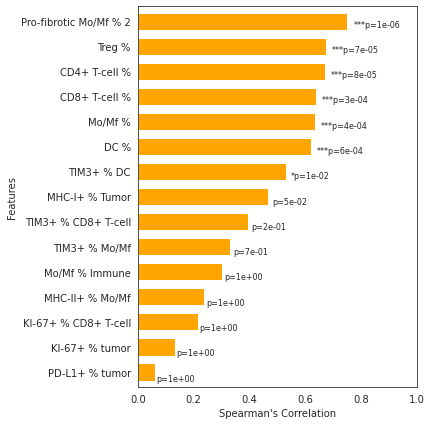

In [18]:
ax=sclc_ct_corr_reg_df.loc['PLCG2+ % tumor masked',['Treg %','DC %','CD4+ T-cell %',
                     'CD8+ T-cell %', 'Mo/Mf %', 'MHC-I+ % Tumor','Pro-fibrotic Mo/Mf % 2',
                    'PD-L1+ % tumor', 'KI-67+ % tumor','Mo/Mf % Immune',
                    'MHC-II+ % Mo/Mf','KI-67+ % CD8+ T-cell', 'TIM3+ % Mo/Mf', 'TIM3+ % DC',
       'TIM3+ % CD8+ T-cell']].sort_values(ascending=True).plot.barh(figsize=(5,7),color='orange',width=0.7,
                                                        )
for i,p in enumerate(ax.patches):
    ax.annotate(add_list[-(i+1)]+'p='+p_value_adjusted_text[-(i+1)], ( p.get_width() * 1.03,p.get_y() * 1.01),fontsize=8)
ax.set_xlim(right=1)
ax.set_ylabel('Features')
ax.set_xlabel("Spearman's Correlation")
ax.grid(False)
plt.tick_params(bottom = False,left = False)


### Fig 7F

In [19]:
X= sample_df['PLCG2+ % tumor masked']
y=sample_df['Pro-fibrotic Mo/Mf % 2'] #Pro-fibrotic % Mo/Mf 2  Pro-fibrotic Mo/Mf % 2
cvar = np.atleast_2d(cov)
beta_x = np.linalg.lstsq(cvar, X, rcond=None)[0]
beta_y = np.linalg.lstsq(cvar, y, rcond=None)[0]
res_x = X - np.dot(cvar, beta_x)
res_y = y - np.dot(cvar, beta_y)

In [20]:
spearmanr(res_x,res_y)

SpearmanrResult(correlation=0.7508007488026384, pvalue=8.685896904720473e-08)

<AxesSubplot:xlabel='PLCG2+ % tumor masked', ylabel='Pro-fibrotic Mo/Mf % 2'>

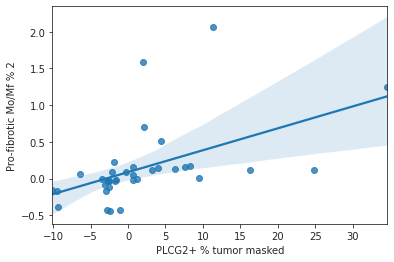

In [21]:
sns.regplot(res_x,res_y)

### Figure 7I

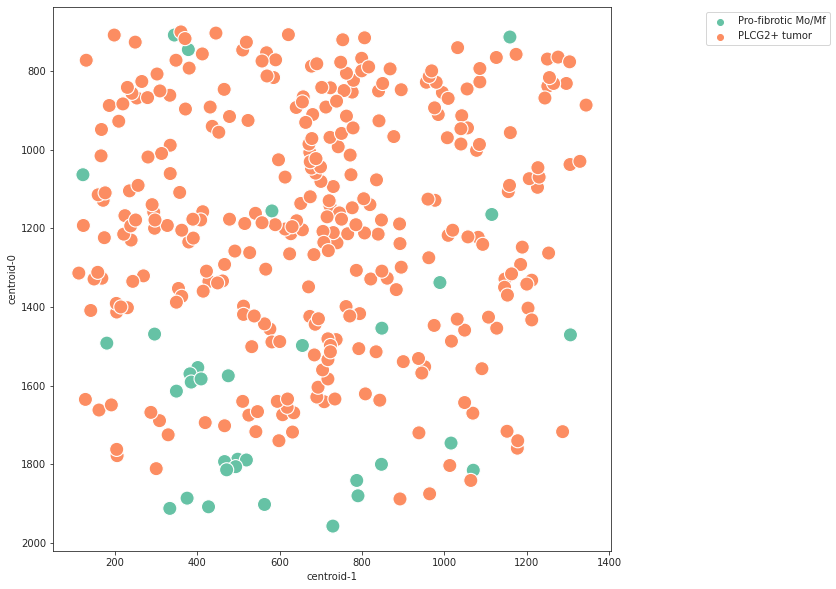

In [22]:
plt.figure(figsize=(10,10))
crop_coord2=[100,700]
crop_size=1280
fov1 = cell_data_lite[cell_data_lite.TMA_coord=='X1Y9'].copy()
fov1=fov1[fov1.PLCG2_Myeloid!='Others']
fov1=fov1[(fov1['centroid-1']>crop_coord2[0])&(fov1['centroid-1']<(crop_coord2[0]+crop_size))&(fov1['centroid-0']>crop_coord2[1])&(fov1['centroid-0']<(crop_coord2[1]+crop_size))]

sns.scatterplot(x='centroid-1',y='centroid-0',data=fov1.sort_values("PLCG2_Myeloid",ascending=False),s=200,alpha=1,hue='PLCG2_Myeloid',palette='Set2',legend=True)
plt.grid(False)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.4, 1))

### Fig S4 F

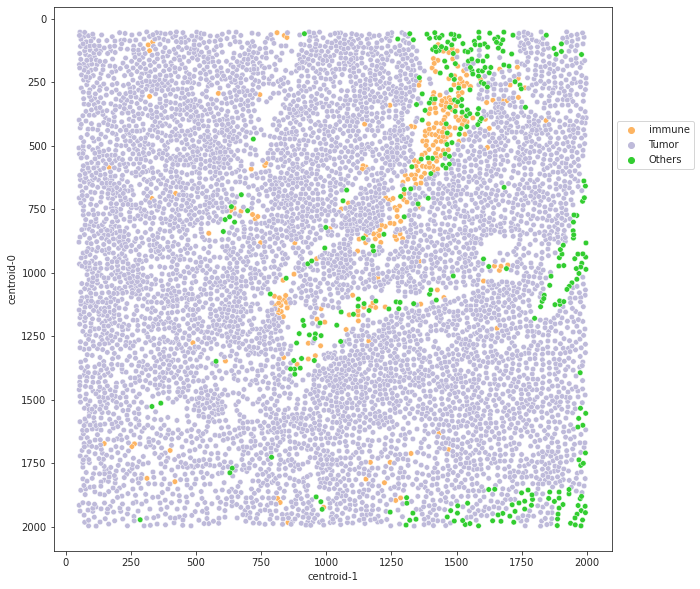

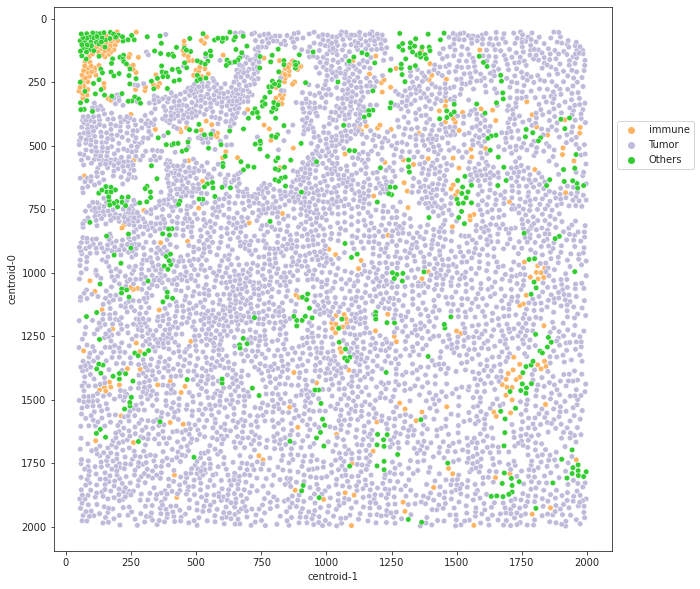

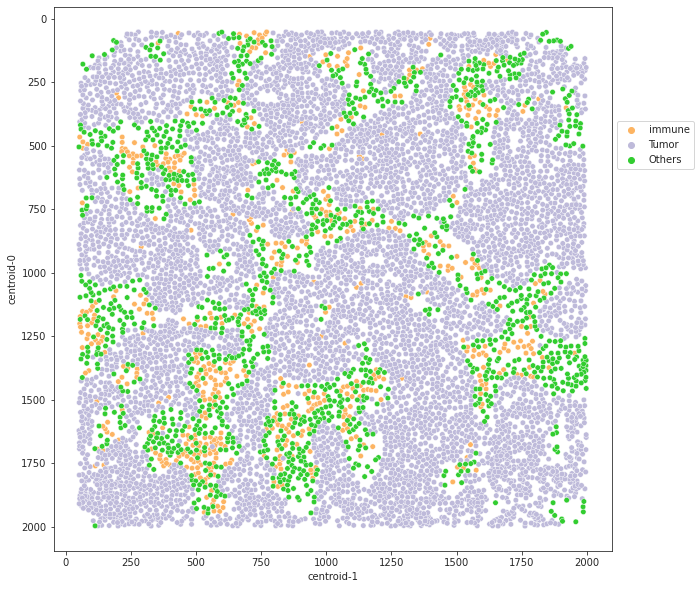

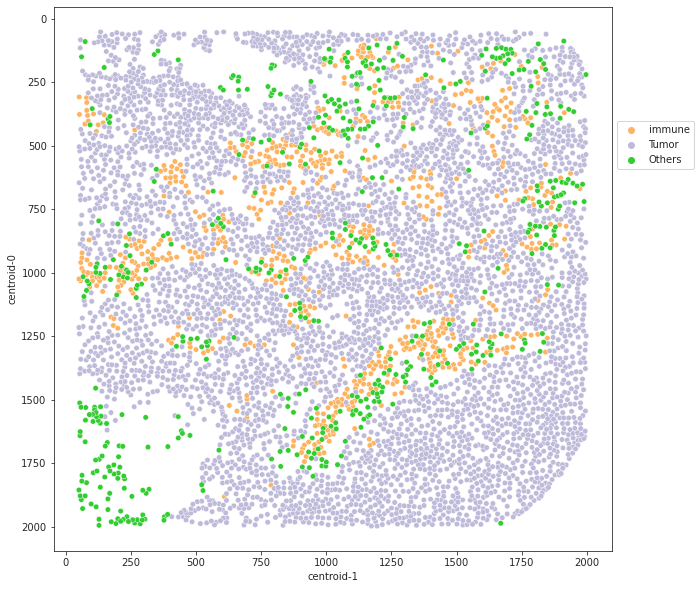

In [23]:
cmap3=['#fdb462','#bebada','#32CD30'] ##B2D2A4 8dd3c7
fov_list = ['X2Y10','X5Y9','X6Y6','X6Y10']
for fov in fov_list:
    plt.figure(figsize=(10,10))
    fov1 = cell_data_lite[cell_data_lite.TMA_coord==fov].copy()
    sns.scatterplot(x='centroid-1',y='centroid-0',data=fov1.sort_values("immune vs tumor updated",ascending=False),s=30,alpha=1,hue='immune vs tumor updated',palette=cmap3,legend=True)
    plt.gca().invert_yaxis()
    plt.grid(False)
    plt.legend(bbox_to_anchor=(1, 0.8))
 

### Figure S4G

In [24]:
import statsmodels.api as sm

In [25]:
X=sclc_sample_df[['primary','treated','combined','NEUROD1']][~sclc_sample_df['NEUROD1'].isna()]*1
y=sclc_sample_df['hot'][~sclc_sample_df['NEUROD1'].isna()]*1
X2 = sm.add_constant(X)
est = sm.Logit(y.values, X2)
est2 = est.fit()
print(est2.summary())

         Current function value: 0.500035
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   33
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            4
Date:                Mon, 11 Oct 2021   Pseudo R-squ.:                  0.2542
Time:                        21:10:21   Log-Likelihood:                -16.501
converged:                      False   LL-Null:                       -22.126
Covariance Type:            nonrobust   LLR p-value:                   0.02390
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.3893   6921.128     -0.003      0.998   -1.36e+04    1.35e+04
primary       18.3005   6921.128      0.003      0.998   -1.35e+0

/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [26]:
coefs = [0,0.68,-0.25,-2.04]#[0.2637,0.1110,-0.0439,-0.4571]
errors = [0,1.25,1.05,0.98]#[0.232,0.227,0.192,0.186]
pvalues = est2.pvalues[1:]#[0.265,0.629,0.821,0.021]
star=[]
for pvalue in pvalues:
    mark = ''
    if pvalue<0.05:
        mark+='*'
    star.append(mark)

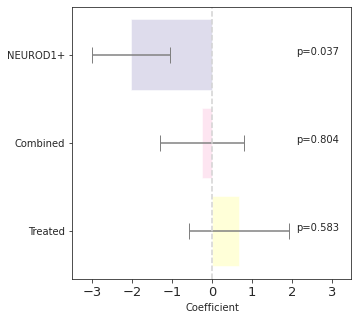

In [27]:
cmap10=['#ffffb3','#fccde5','#bebada','#fb8072','#80b1d3','#d9d9d9','#b3de69','#8dd3c7','#fdb462']
fig, ax = plt.subplots(figsize=(5,5))
#plt.figure(figsize=(5,5))
ax.barh( ['Primary','Treated','Combined','NEUROD1+'][1:],coefs[1:], xerr=errors[1:], align='center',color=cmap10, alpha=0.5, ecolor='gray', capsize=8)
ax.set_xlabel('Coefficient')

for i,p in enumerate(ax.patches):
    ax.annotate((star[i]+'p=%.3f' % pvalues[1:][i]), ( 2.1,p.get_y() * 1+0.4),fontsize=10,transform=ax.transAxes)
#ax.set_yticklabels(labels=['Primary','Treated','Combined','NEUROD1+'])
ax.grid(False)
ax.set_xlim(-3.5,3.5,)
stepsize=0.25
start, end = ax.get_xlim()
#ax.xaxis.set_ticks(np.arange(start, end, stepsize))
ax.xaxis.set_tick_params(labelsize=13)
plt.axvline(x=0, label='Coefficient=0', c='lightgray',ls='--')
#plt.legend( loc='upper right')